# Conversion Rate EDA
Reference:
https://michael-fuchs-python.netlify.app/2020/09/01/marketing-conversion-rate-analytics/

The table is "conversion data". It has infomation about signed-in users during one session. Each row is a user session.

Columns:

- `country`: user country based on the IP address
- `age`: user age. Self-reported at sign-in step
- `new_user` : whether the user created the account during this session or had already an account and simply came back to the site
- `source`: marketing channel source
  - `Ads`: came to the site by clicking on an advertisement
  - `Seo`: came to the site by clicking on search results
  - `Direct`: came to the site by directly typing the URL on the browser
- `total_pages_visited`: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- `converted`: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Conversion.csv')
df.head(3)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0


# Key Questions

- How to increase the sales? Ans: Traffic x Conversion Rate x Average Order Value = Sales

- KPI in this case? Ans: Conversion Rate (CVR).

- Is any feature important for the conversion rate?

- Which country has the highest conversion rate? and why?

- Which marketing channel has the highest conversion rate? and why?

- How to increase the conversion rate?

Other

- Is the ratio of new users to returning users different in different countries?

# 1. Data Observation

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [8]:
# Package for EDA
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title='Conversion Report', explorative=True)
# profile.to_file('ConversionReport.html')

# Descriptive statistic
descriptiveStat = df.describe()
print(descriptiveStat, '\n')

# Calculate Convertion Rate
print('Conversion: %i out of %i' %(df['converted'].sum(),df.shape[0]))
print('Conversion Rate: %0.2f%%' %(df['converted'].mean()*100))

# 觀察發現 age 可能有離群值(max=123)
# 觀察發現 total_pages_visited 可能有離群值(max=29)

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000 

Conversion: 10200 out of 316200
Conversion Rate: 3.23%


In [69]:
df.groupby(['new_user']).size()

new_user
0     99456
1    216744
dtype: int64

In [70]:
df.groupby(['country']).size()

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64

In [74]:
df.groupby(['source']).size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64

## 2. Data Cleaning

Missing Value Check:

No missing values in the dataset.

In [9]:
# missing value
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

Outlier Check: 

There are some outliers in the dataset.
- The maximum age is 123, which is not reasonable. 
- The maximum total_pages_visited is 29, which may be an outlier.

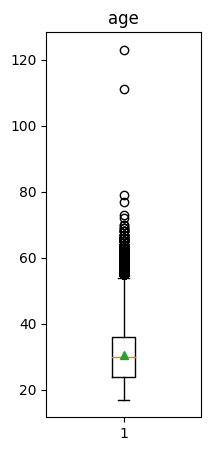

In [23]:
# Boxplot 觀察 age 分佈狀況
# 超過 Q3+1.5IQR ＆ Q1-1.5IQR 為離群值
age = df['age']
plt.figure(figsize=(2,5))
plt.boxplot(age, showmeans=True)
plt.title('age')
plt.show()

Skewness: 0.52
Kurtosis: -0.03


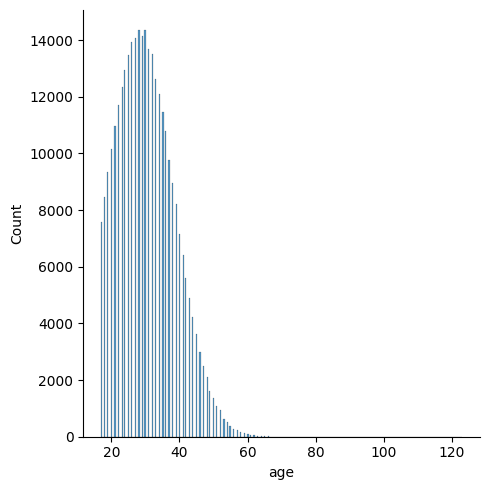

In [26]:
sns.displot(age)

# Skewness and Kurtosis
print("Skewness: {:.2f}".format(df['age'].skew())) #0.51
print("Kurtosis: {:.2f}".format(df['age'].kurt())) #-0.04

In [ ]:
df[df['age'] > 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


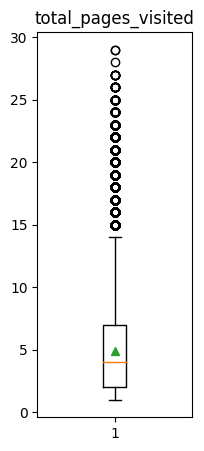

In [27]:
total_pages_visited = df['total_pages_visited']
plt.figure(figsize=(2,5))
plt.boxplot(total_pages_visited, showmeans=True)
plt.title('total_pages_visited')
plt.show()

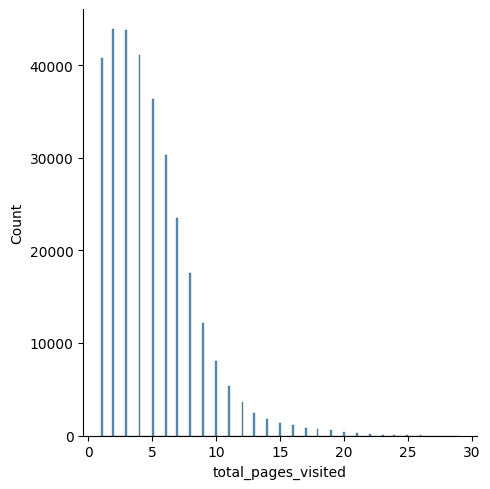

In [28]:
sns.displot(total_pages_visited)

In [30]:
df[df['total_pages_visited'] > 15]

,country,age,new_user,source,total_pages_visited,converted
54,US,25,1,Direct,18,1
87,US,18,0,Direct,19,1
130,US,17,0,Ads,19,1
213,US,17,0,Seo,21,1
229,US,35,0,Seo,17,1
...,...,...,...,...,...,...
315553,UK,22,0,Seo,17,1
315748,China,26,1,Seo,18,0
316055,US,26,1,Ads,19,1
316087,US,19,1,Ads,19,1


Most of the outliers are converted sessions. 

We don't need to remove the outliers in this case because the outliers are reasonable.

## 3. Exploratory Data Analysis

#### Correlation Analysis

<AxesSubplot: >

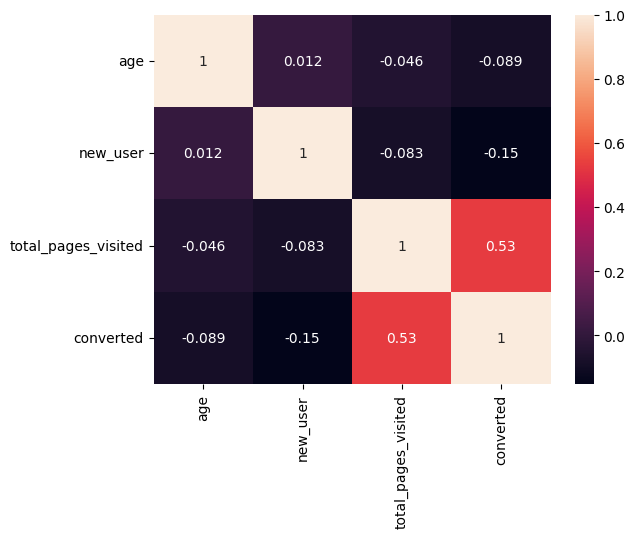

In [45]:
# Correlation Matrix
sns.heatmap(df[['age','new_user','total_pages_visited','converted']].corr(), annot=True)

According to the correlation matrix, the total_pages_visited is the most important feature for the conversion rate.

#### Coversion Rate Analysis

In [ ]:
# Observate the CVR by different features(country, newuser)
# 觀察不同國家(country)的新舊訪客(new_user)，在不同管道(source)下的轉換率
# Using Pivot Table
pivotTable = pd.pivot_table(df, index=['country','new_user'], columns='source',values='converted', aggfunc='mean')
pivotTable

source                 Ads    Direct       Seo
country new_user                              
China   0         0.003363  0.002661  0.002657
        1         0.000666  0.000820  0.000609
Germany 0         0.154412  0.116408  0.141284
        1         0.024448  0.024465  0.026934
UK      0         0.125320  0.094571  0.117235
        1         0.023109  0.024112  0.023555
US      0         0.090679  0.071999  0.084901
        1         0.017314  0.014706  0.016809

In [40]:
# Using Groupby() (alternative)
df.groupby(['country','new_user','source'])['converted'].mean().apply(lambda x: str(round(x * 100,2)) + '%')

country  new_user  source
China    0         Ads        0.34%
                   Direct     0.27%
                   Seo        0.27%
         1         Ads        0.07%
                   Direct     0.08%
                   Seo        0.06%
Germany  0         Ads       15.44%
                   Direct    11.64%
                   Seo       14.13%
         1         Ads        2.44%
                   Direct     2.45%
                   Seo        2.69%
UK       0         Ads       12.53%
                   Direct     9.46%
                   Seo       11.72%
         1         Ads        2.31%
                   Direct     2.41%
                   Seo        2.36%
US       0         Ads        9.07%
                   Direct      7.2%
                   Seo        8.49%
         1         Ads        1.73%
                   Direct     1.47%
                   Seo        1.68%
Name: converted, dtype: object

Compare the conversion rate by different features.

In [59]:
# by country
df.groupby(['country'])['converted'].mean().apply(lambda x: str(round(x * 100, 2)) + ' %')

country
China      0.13 %
Germany    6.25 %
UK         5.26 %
US         3.78 %
Name: converted, dtype: object

In [60]:
# by new user
df.groupby(['new_user'])['converted'].mean().apply(lambda x: str(round(x * 100, 2)) + ' %')

new_user
0    7.2 %
1    1.4 %
Name: converted, dtype: object

In [61]:
# by source
df.groupby(['source'])['converted'].mean().apply(lambda x: str(round(x * 100, 2)) + ' %')

source
Ads       3.45 %
Direct    2.82 %
Seo       3.29 %
Name: converted, dtype: object

<AxesSubplot: xlabel='age'>

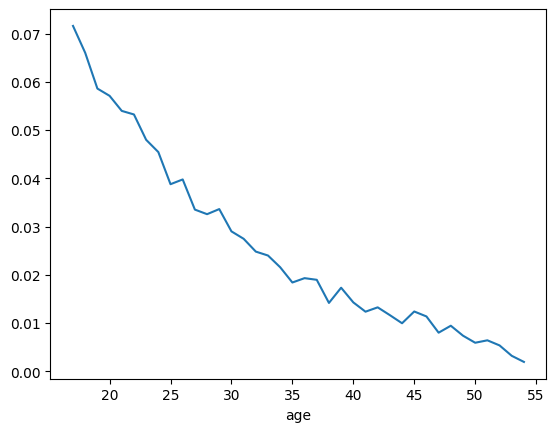

In [ ]:
# by age (remove 2 outlier)
# IQR Method
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
age_lower_bound = Q1 - 1.5 * IQR
age_upper_bound = Q3 + 1.5 * IQR
# remove outlier
filtered_df = df[(df['age'] >= age_lower_bound) & (df['age'] <= age_upper_bound)]
# plot
filtered_df.groupby(['age'])['converted'].mean().plot()

In [6]:
cvr = df.groupby(['country', 'source'])['converted'].mean().reset_index()
cvr.rename(columns={'converted': 'conversion_rate'}, inplace=True)

print(cvr)

    country  source  conversion_rate
0     China     Ads         0.001484
1     China  Direct         0.001374
2     China     Seo         0.001224
3   Germany     Ads         0.066755
4   Germany  Direct         0.053422
5   Germany     Seo         0.064055
6        UK     Ads         0.055630
7        UK  Direct         0.046267
8        UK     Seo         0.053905
9        US     Ads         0.040580
10       US  Direct         0.032909
11       US     Seo         0.038508


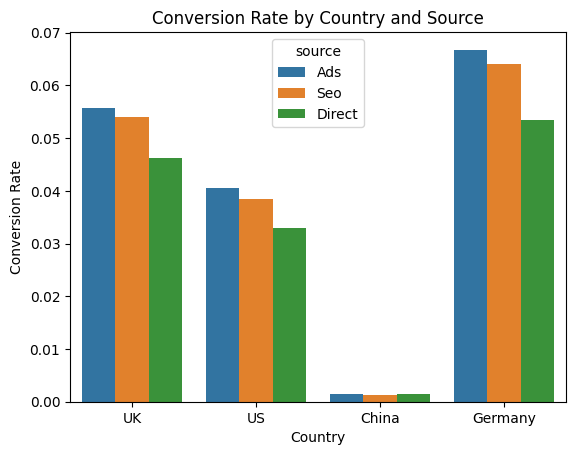

In [3]:
sns.barplot(x='country', y='converted', hue='source', data=df, errorbar=None)
plt.title('Conversion Rate by Country and Source')
plt.ylabel('Conversion Rate')
plt.xlabel('Country')
plt.show()

#### Old User ratio by country and source
Check if the ratio of new users to returning users is different in different countries and sources.

In [10]:
# no difference
df.groupby(['country','source'])['new_user'].mean()

country  source
China    Ads       0.696628
         Direct    0.698677
         Seo       0.699532
Germany  Ads       0.674468
         Direct    0.685056
         Seo       0.675373
UK       Ads       0.681832
         Direct    0.685563
         Seo       0.676022
US       Ads       0.682872
         Direct    0.682291
         Seo       0.681333
Name: new_user, dtype: float64

## 4. Insights and Recommendations

`Insights:`

- Since the market environment between each country is quite different, the overll data analysis may not be suitable for each country. We need to analyze the data by country.

- We observered that the new_user has a lower CVR than the old_user, no matter in which country or which marketing channel.

- The CVR in Germany is the highest, however the traffic in Germany is the lowest.

- The CVR in China is the lowest, however the traffic in China is the second highest.

- There is a negative correlation between the age and the CVR. Which means the older users have a lower CVR.

`Recommendations:`

- Focus on CRM for turning the new users into returning users.

- Increase the traffic in Germany.

- Increase the CVR in China.

- Focus on the younger users. (In this case, we don't take order value into consideration.)